In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import tensorflow as tf
from tensorflow.keras import layers, models

2023-05-13 12:39:43.794803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions 

In [2]:
def LSfitw(y,M,Sigma_inv):
    #finds beta such that ||y-M*beta||*2 is minimal but with diagonal weight
    #Sigma_inv should be Sigma^^(-1/2) so iv std matrix
    Mt = np.dot(Sigma_inv,M)
    yt = np.dot(Sigma_inv,y)
    A =np.dot(Mt.T,Mt) # this and the following steps implement the LS iversion formula
    B = np.dot(Mt.T,yt)
    betaest = np.dot(np.linalg.inv(A),B)
    yest = np.dot(M,betaest)
    return yest


def my_GLS(t,y,EB, periods):
    Sigma_inv = np.diagflat(1./EB)
    power=[]
    N = len(t)
    un = np.ones(np.shape(y)) # a vector of ones
    unt = np.dot(Sigma_inv,un)
    yt = np.dot(Sigma_inv,y)
    yest0 = (np.dot(yt,unt))/(np.dot(unt,unt))*un
    RSS0 = np.sum(((y-yest0)/EB)**2)
    for i in range(len(periods)):
        # create M0 = constant
        # create M1 = constant + sinusoid
        M1 = (np.concatenate(([un], [np.cos(2*np.pi*t/periods[i])], [np.sin(2*np.pi*t/periods[i])]), axis=0)).T # the design matric M : shape is 20 *2        
        yest1 = LSfitw(y,M1,Sigma_inv)
        RSS1 = np.sum(((y-yest1)/EB)**2)
        power.append((RSS0-RSS1)/RSS0)
    return power

def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    # VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz

           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_regular_data_H0(params_gr, params_act, N, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    # print(k.get_parameter_vector())
    
    gp = george.GP(k)

    # generate synthetic dataset
    yact = gp.sample(t)
    
    # =========================================================================
    # Generate the intrincsic errors
    sig = 0.30 # m/s
    yerr = np.random.normal(loc=0, scale=sig, size=N) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors + planet if params_pl
    ytot = ygr + yact + yerr * np.random.randn(N)
    
    return ytot, yerr




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def print_4periodogramme(LS_p,label,freq_pl,i):
    LS = LS_p[:,i,:]
    f1,f2,f3,f4 = freq_pl[i,:]
    l1,l2,l3,l4 = label[i,:]
    
    plt.figure()
    plt.suptitle("4 Lomb-Scargle peridogramme generated by removing the best fit\n"+str(i)+" planet")
    plt.subplot(411),plt.plot(freq, LS[:,0] , label =l1), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,0]),max(LS[:,0])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,0]),max(LS[:,0])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,0]),max(LS[:,0])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,0]),max(LS[:,0])],'y--')

    plt.subplot(412), plt.plot(freq, LS[:,1] , label =l2), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,1]),max(LS[:,1])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,1]),max(LS[:,1])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,1]),max(LS[:,1])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,1]),max(LS[:,1])],'y--')

    plt.subplot(413), plt.plot(freq, LS[:,2] , label =l3), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,2]),max(LS[:,2])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,2]),max(LS[:,2])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,2]),max(LS[:,2])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,2]),max(LS[:,2])],'y--')

    plt.subplot(414 ), plt.plot(freq, LS[:,3] , label = l4), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,3]),max(LS[:,3])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,3]),max(LS[:,3])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,3]),max(LS[:,3])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,3]),max(LS[:,3])],'y--')
    
    plt.xlabel("Frequency (day⁻¹)")
    plt.ylabel("Power")
    

def generate_4_periodogrammes(t,f, y, freq_pl,nbr_planete):
    """
    Parameters
    ----------
    t : time (day)
    f : frequency ( day⁻1)
    y : original time serie

    Returns
    -------
    4 times series with their lomb-scargle 
    """
    y_t = np.zeros((len(t), 4)) #time series
    LS  = np.zeros((len(f), 4)) # 4 lombscargle 
    nbr_planete_now = np.copy(nbr_planete)
    label= np.zeros(4) #(1 if max = freq_pl, 0 else)
    max_value = np.zeros((2,4)) # (argmax, max)
    
    y_t[:,0] = y 
    
    for i in range(3):
        LS_i =  LombScargle(t, y_t[:,i])
        LS[:,i] = LS_i.power(f,method='cython')
        best_freq = round(f[np.argmax(LS[:,i])],3)
        #print("meilleur fit : ",best_freq)
        max_value[0,i], max_value[1,i] = best_freq, np.max(LS[:,i]) 
                
        if ( any(np.isclose(freq_pl, best_freq, atol=0.001)) ):
            label[i] = 1
            freq_pl[ np.where( np.isclose(freq_pl, best_freq, atol=0.001) ) ] = 0
            nbr_planete_now[i+1:] = nbr_planete_now[i] - 1
        else:
            label[i] = 0
            
        y_fit = LS_i.model(t,best_freq)
        y_t[:,i+1] = y_t[:,i] - y_fit
      
    LS_i = LombScargle(t, y_t[:,3])
    LS[:,3] = LS_i.power(f,method='cython')
    best_freq = round(f[np.argmax(LS[:,3])],3)
    #print("meilleur fit : ",best_freq)
    max_value [0,3], max_value[1,3] =  best_freq, np.max(LS[:,3])
    
    if (any(np.isclose(freq_pl, best_freq, atol=0.001))):
        label[3] = 1
        freq_pl[np.where( np.isclose(freq_pl, best_freq, atol=0.001) )] = 0
    else:
        label[3] = 0
    
    #print("label = ", label)
    
    return LS, label, max_value, nbr_planete_now     



def generate_data(t,dt,Ttot,freq,params_gr, params_act):
    
    time_series = np.zeros((len(t),5))
    LS = np.zeros((len(freq),5,4))
    freq_pl = np.zeros((5,4))
    nbr_planete = np.zeros((5,4))
    label = np.zeros((5,4))
    max_value = np.zeros((2,5,4))
    
    y_noise, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t) 
    
    #print("freq planet : ",freq_pl[0,:])
    time_series[:,0] = y_noise #Without planet
    LS[:,0,:], label[0,:], max_value[:,0,:],nbr_planete[0,:] = generate_4_periodogrammes(t, freq, np.copy(y_noise), freq_pl[0,:],nbr_planete[0,:]) #Without planet
    
    for i in range(1,5):
        y_i = y_noise
        for k in range(1,i+1):
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            freq_pl[i,k-1] = round(1/Ppl,3)
            
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        
        nbr_planete[i,:] = i
        #print("freq planet : ",freq_pl[i,:])
        time_series[:,i] = y_i
        LS[:,i,:], label[i,:], max_value[:,i,:],nbr_planete[i,:] = generate_4_periodogrammes(t, freq, y_i,np.copy(freq_pl[i,:]),nbr_planete[i,:])
        
        
    return time_series, LS, label, max_value, freq_pl,nbr_planete


In [3]:
#Parameters for activity signal

# Grannulation + Oscillation
A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

##Activity signal
Prot = 62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

amp  = gamma.rvs(2.0, 0.5) 
epsilon = uniform.rvs(0.5, 1)
tau = np.random.normal(3*Prot, 0.1*Prot) 
gam  = 2.0/epsilon #not change
logP = np.log(Prot) #not change 
met  = 1.0 # not change 

params_act = [amp, gam, logP, met]


In [4]:
#Generate time and frequency

#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days
dt = Ttot*facteur_surech/(N-1) #After sampling


# Irregular sampling 1 : with normal distribution
facteur_ech = 10
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ]
ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1] = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-2):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i+1] =  t_over[ind]
    
fmin = 1/Ttot
fmax = (1/dt)/2 
freq = np.arange(fmin,fmax,fmin/10)

In [10]:
# Function for create training set. Same number of specif case ( w/o planet, 1 planet, 2 planets ...). A pourcentage 
# of 40% of positif case need to be reached

def create_set1(nbr_periodogramme, pourcentage_positive,t, dt, Ttot, freq):
    
    count_positif = 0
    count_negatif = 0
    nbr_ech = nbr_periodogramme/5
    count_ech = np.zeros(5)
    
    X_train_LS = []
    X_train_max_values = []
    Y_train = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #create 40% positif label
    while( count_positif < pourcentage_positive*nbr_periodogramme) :
        ##Activity signal
        Prot = 62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(1,5):
            for j in range(4):
                if (label[i,j] == 1):
                    X_train_LS.append(LS[:,i,j])
                    X_train_max_values.append(max_value[:,i,j])
                    Y_train.append(1)
                    count_positif +=1
                    count_ech[ round(nbr_planete[i,j]) ] +=1
    
        print("Nbr positif label : ",count_positif)
        print("Nbr ech par cas de figure : ", count_ech)
        
    print("\nPositive label termined, nbr count positive label = ", count_positif)    
    print("Nbr ech par cas de figure : ", count_ech,"\n")
    nbr_planet_cas_positif = np.copy(count_ech)
    time.sleep(5)
    
    
    #create negatif label 
    while ( (count_negatif < (1-pourcentage_positive)) or (any(count_ech<nbr_ech)) ):
      
        ##Activity signal
        Prot = 62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(5):
            for j in range(4):
                
                if ( (label[i,j] == 0)  and (count_ech[ round(nbr_planete[i,j]) ] < nbr_ech) ):
                        X_train_LS.append(LS[:,i,j])
                        X_train_max_values.append(max_value[:,i,j])
                        Y_train.append(0)
                        count_ech[ round(nbr_planete[i,j]) ] +=1
                        count_negatif += 1
                        
        print("nbr ech ",count_ech)
        print("count negatif = ",count_negatif)

    
    
    print("\nTemps total = ", round(time.time() - start,2))
    print("Nbr ech par cas de figure : ", count_ech)
    print("Nbr positive label : ",count_positif, ", Nbr negative label : ",count_negatif)
    
    print("\nRepartition label positif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round(nbr_planet_cas_positif[0]/count_positif,3),"%")
    print(" - 1 planete ", 100*round(nbr_planet_cas_positif[1]/count_positif,3),"%")
    print(" - 2 planetes ", 100*round(nbr_planet_cas_positif[2]/count_positif,3),"%")
    print(" - 3 planetes ", 100*round(nbr_planet_cas_positif[3]/count_positif,3),"%")
    print(" - 4 planetes ", 100*round(nbr_planet_cas_positif[4]/count_positif,3),"%")
    
    print("Repartition label negatif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round((count_ech[0]-nbr_planet_cas_positif[0])/count_negatif,3),"%")
    print(" - 1 planete ", 100*round((count_ech[1]-nbr_planet_cas_positif[1])/count_negatif,3),"%")
    print(" - 2 planetes ", 100*round((count_ech[2]-nbr_planet_cas_positif[2])/count_negatif,3),"%")
    print(" - 3 planetes ", 100*round((count_ech[3]-nbr_planet_cas_positif[3])/count_negatif,3),"%")
    print(" - 4 planetes ", 100*round((count_ech[4]-nbr_planet_cas_positif[4])/count_negatif,3),"%")
    
    print("\nRepartion classe positif/negatif : ", 100*round(count_positif/len(X_train_LS),2),"% , ", 100*round(count_negatif/len(X_train_LS),2),"%")
    
    print("\nNbr data : ", len(Y_train) )
    
    return X_train_LS, X_train_max_values, Y_train


In [11]:
#Create data for training the neural network
nbr_periodogramme_train = 13700
pourcentage_positive = 0.4
X_train_LS, X_train_max_values, Y_train = create_set1(nbr_periodogramme_train,pourcentage_positive,t, dt, Ttot, freq)

Nbr positif label :  5
Nbr ech par cas de figure :  [0. 1. 1. 2. 1.]
Nbr positif label :  9
Nbr ech par cas de figure :  [0. 1. 2. 4. 2.]
Nbr positif label :  12
Nbr ech par cas de figure :  [0. 1. 3. 5. 3.]
Nbr positif label :  16
Nbr ech par cas de figure :  [0. 2. 4. 6. 4.]
Nbr positif label :  22
Nbr ech par cas de figure :  [0. 3. 6. 8. 5.]
Nbr positif label :  26
Nbr ech par cas de figure :  [0. 3. 8. 9. 6.]
Nbr positif label :  29
Nbr ech par cas de figure :  [ 0.  4.  8. 10.  7.]
Nbr positif label :  35
Nbr ech par cas de figure :  [ 0.  5. 10. 12.  8.]
Nbr positif label :  39
Nbr ech par cas de figure :  [ 0.  6. 11. 13.  9.]
Nbr positif label :  44
Nbr ech par cas de figure :  [ 0.  8. 12. 14. 10.]
Nbr positif label :  48
Nbr ech par cas de figure :  [ 0.  8. 13. 16. 11.]
Nbr positif label :  52
Nbr ech par cas de figure :  [ 0. 10. 14. 17. 11.]
Nbr positif label :  56
Nbr ech par cas de figure :  [ 0. 10. 16. 18. 12.]
Nbr positif label :  59
Nbr ech par cas de figure :  [ 0.

Nbr positif label :  508
Nbr ech par cas de figure :  [  0.  93. 156. 161.  98.]
Nbr positif label :  514
Nbr ech par cas de figure :  [  0.  94. 158. 163.  99.]
Nbr positif label :  516
Nbr ech par cas de figure :  [  0.  94. 159. 163. 100.]
Nbr positif label :  520
Nbr ech par cas de figure :  [  0.  94. 160. 165. 101.]
Nbr positif label :  524
Nbr ech par cas de figure :  [  0.  95. 161. 166. 102.]
Nbr positif label :  530
Nbr ech par cas de figure :  [  0.  96. 163. 168. 103.]
Nbr positif label :  533
Nbr ech par cas de figure :  [  0.  96. 163. 170. 104.]
Nbr positif label :  537
Nbr ech par cas de figure :  [  0.  97. 163. 172. 105.]
Nbr positif label :  542
Nbr ech par cas de figure :  [  0.  98. 164. 174. 106.]
Nbr positif label :  546
Nbr ech par cas de figure :  [  0.  98. 166. 175. 107.]
Nbr positif label :  552
Nbr ech par cas de figure :  [  0.  99. 168. 177. 108.]
Nbr positif label :  556
Nbr ech par cas de figure :  [  0.  99. 170. 178. 109.]
Nbr positif label :  560
Nbr

Nbr positif label :  978
Nbr ech par cas de figure :  [  0. 178. 295. 314. 191.]
Nbr positif label :  981
Nbr ech par cas de figure :  [  0. 178. 296. 315. 192.]
Nbr positif label :  984
Nbr ech par cas de figure :  [  0. 179. 297. 316. 192.]
Nbr positif label :  989
Nbr ech par cas de figure :  [  0. 179. 299. 318. 193.]
Nbr positif label :  996
Nbr ech par cas de figure :  [  0. 181. 301. 320. 194.]
Nbr positif label :  1001
Nbr ech par cas de figure :  [  0. 183. 303. 321. 194.]
Nbr positif label :  1003
Nbr ech par cas de figure :  [  0. 183. 304. 322. 194.]
Nbr positif label :  1008
Nbr ech par cas de figure :  [  0. 184. 306. 323. 195.]
Nbr positif label :  1017
Nbr ech par cas de figure :  [  0. 187. 309. 325. 196.]
Nbr positif label :  1021
Nbr ech par cas de figure :  [  0. 187. 310. 327. 197.]
Nbr positif label :  1024
Nbr ech par cas de figure :  [  0. 187. 311. 328. 198.]
Nbr positif label :  1030
Nbr ech par cas de figure :  [  0. 189. 313. 329. 199.]
Nbr positif label :  

Nbr positif label :  1453
Nbr ech par cas de figure :  [  0. 274. 435. 458. 286.]
Nbr positif label :  1458
Nbr ech par cas de figure :  [  0. 275. 437. 459. 287.]
Nbr positif label :  1463
Nbr ech par cas de figure :  [  0. 276. 439. 460. 288.]
Nbr positif label :  1467
Nbr ech par cas de figure :  [  0. 277. 439. 462. 289.]
Nbr positif label :  1472
Nbr ech par cas de figure :  [  0. 278. 440. 464. 290.]
Nbr positif label :  1477
Nbr ech par cas de figure :  [  0. 279. 442. 465. 291.]
Nbr positif label :  1480
Nbr ech par cas de figure :  [  0. 279. 443. 466. 292.]
Nbr positif label :  1487
Nbr ech par cas de figure :  [  0. 280. 446. 468. 293.]
Nbr positif label :  1493
Nbr ech par cas de figure :  [  0. 282. 447. 470. 294.]
Nbr positif label :  1498
Nbr ech par cas de figure :  [  0. 284. 449. 471. 294.]
Nbr positif label :  1503
Nbr ech par cas de figure :  [  0. 285. 450. 473. 295.]
Nbr positif label :  1509
Nbr ech par cas de figure :  [  0. 286. 452. 475. 296.]
Nbr positif labe

Nbr positif label :  1932
Nbr ech par cas de figure :  [  0. 373. 572. 607. 380.]
Nbr positif label :  1937
Nbr ech par cas de figure :  [  0. 374. 574. 608. 381.]
Nbr positif label :  1943
Nbr ech par cas de figure :  [  0. 376. 576. 609. 382.]
Nbr positif label :  1947
Nbr ech par cas de figure :  [  0. 377. 577. 610. 383.]
Nbr positif label :  1951
Nbr ech par cas de figure :  [  0. 378. 578. 611. 384.]
Nbr positif label :  1955
Nbr ech par cas de figure :  [  0. 379. 579. 612. 385.]
Nbr positif label :  1959
Nbr ech par cas de figure :  [  0. 380. 580. 613. 386.]
Nbr positif label :  1964
Nbr ech par cas de figure :  [  0. 381. 581. 615. 387.]
Nbr positif label :  1969
Nbr ech par cas de figure :  [  0. 383. 582. 616. 388.]
Nbr positif label :  1970
Nbr ech par cas de figure :  [  0. 383. 582. 617. 388.]
Nbr positif label :  1974
Nbr ech par cas de figure :  [  0. 383. 584. 618. 389.]
Nbr positif label :  1978
Nbr ech par cas de figure :  [  0. 384. 585. 619. 390.]
Nbr positif labe

Nbr positif label :  2395
Nbr ech par cas de figure :  [  0. 458. 704. 755. 478.]
Nbr positif label :  2402
Nbr ech par cas de figure :  [  0. 460. 706. 757. 479.]
Nbr positif label :  2405
Nbr ech par cas de figure :  [  0. 460. 706. 759. 480.]
Nbr positif label :  2409
Nbr ech par cas de figure :  [  0. 460. 707. 761. 481.]
Nbr positif label :  2414
Nbr ech par cas de figure :  [  0. 460. 709. 763. 482.]
Nbr positif label :  2419
Nbr ech par cas de figure :  [  0. 461. 710. 765. 483.]
Nbr positif label :  2422
Nbr ech par cas de figure :  [  0. 461. 711. 766. 484.]
Nbr positif label :  2428
Nbr ech par cas de figure :  [  0. 462. 713. 768. 485.]
Nbr positif label :  2431
Nbr ech par cas de figure :  [  0. 462. 713. 770. 486.]
Nbr positif label :  2435
Nbr ech par cas de figure :  [  0. 463. 714. 771. 487.]
Nbr positif label :  2439
Nbr ech par cas de figure :  [  0. 465. 715. 771. 488.]
Nbr positif label :  2444
Nbr ech par cas de figure :  [  0. 467. 716. 772. 489.]
Nbr positif labe

Nbr positif label :  2865
Nbr ech par cas de figure :  [  0. 554. 839. 901. 571.]
Nbr positif label :  2870
Nbr ech par cas de figure :  [  0. 555. 840. 903. 572.]
Nbr positif label :  2877
Nbr ech par cas de figure :  [  0. 556. 843. 905. 573.]
Nbr positif label :  2882
Nbr ech par cas de figure :  [  0. 558. 844. 906. 574.]
Nbr positif label :  2886
Nbr ech par cas de figure :  [  0. 558. 845. 908. 575.]
Nbr positif label :  2889
Nbr ech par cas de figure :  [  0. 559. 846. 909. 575.]
Nbr positif label :  2893
Nbr ech par cas de figure :  [  0. 560. 847. 910. 576.]
Nbr positif label :  2897
Nbr ech par cas de figure :  [  0. 561. 848. 911. 577.]
Nbr positif label :  2903
Nbr ech par cas de figure :  [  0. 561. 851. 913. 578.]
Nbr positif label :  2908
Nbr ech par cas de figure :  [  0. 561. 853. 915. 579.]
Nbr positif label :  2915
Nbr ech par cas de figure :  [  0. 563. 855. 917. 580.]
Nbr positif label :  2919
Nbr ech par cas de figure :  [  0. 564. 856. 918. 581.]
Nbr positif labe

Nbr positif label :  3356
Nbr ech par cas de figure :  [   0.  656.  988. 1050.  662.]
Nbr positif label :  3358
Nbr ech par cas de figure :  [   0.  656.  988. 1051.  663.]
Nbr positif label :  3361
Nbr ech par cas de figure :  [   0.  657.  988. 1052.  664.]
Nbr positif label :  3366
Nbr ech par cas de figure :  [   0.  658.  989. 1054.  665.]
Nbr positif label :  3370
Nbr ech par cas de figure :  [   0.  658.  991. 1055.  666.]
Nbr positif label :  3376
Nbr ech par cas de figure :  [   0.  659.  993. 1057.  667.]
Nbr positif label :  3380
Nbr ech par cas de figure :  [   0.  660.  993. 1059.  668.]
Nbr positif label :  3384
Nbr ech par cas de figure :  [   0.  662.  994. 1059.  669.]
Nbr positif label :  3387
Nbr ech par cas de figure :  [   0.  662.  995. 1060.  670.]
Nbr positif label :  3391
Nbr ech par cas de figure :  [   0.  663.  996. 1061.  671.]
Nbr positif label :  3396
Nbr ech par cas de figure :  [   0.  665.  997. 1062.  672.]
Nbr positif label :  3401
Nbr ech par cas d

Nbr positif label :  3805
Nbr ech par cas de figure :  [   0.  746. 1119. 1186.  754.]
Nbr positif label :  3810
Nbr ech par cas de figure :  [   0.  748. 1120. 1187.  755.]
Nbr positif label :  3814
Nbr ech par cas de figure :  [   0.  748. 1121. 1189.  756.]
Nbr positif label :  3820
Nbr ech par cas de figure :  [   0.  749. 1123. 1191.  757.]
Nbr positif label :  3825
Nbr ech par cas de figure :  [   0.  750. 1125. 1192.  758.]
Nbr positif label :  3827
Nbr ech par cas de figure :  [   0.  750. 1126. 1192.  759.]
Nbr positif label :  3834
Nbr ech par cas de figure :  [   0.  751. 1129. 1194.  760.]
Nbr positif label :  3840
Nbr ech par cas de figure :  [   0.  753. 1131. 1195.  761.]
Nbr positif label :  3845
Nbr ech par cas de figure :  [   0.  754. 1132. 1197.  762.]
Nbr positif label :  3849
Nbr ech par cas de figure :  [   0.  755. 1133. 1198.  763.]
Nbr positif label :  3855
Nbr ech par cas de figure :  [   0.  757. 1134. 1200.  764.]
Nbr positif label :  3860
Nbr ech par cas d

Nbr positif label :  4272
Nbr ech par cas de figure :  [   0.  834. 1259. 1333.  846.]
Nbr positif label :  4276
Nbr ech par cas de figure :  [   0.  835. 1260. 1334.  847.]
Nbr positif label :  4282
Nbr ech par cas de figure :  [   0.  837. 1262. 1335.  848.]
Nbr positif label :  4287
Nbr ech par cas de figure :  [   0.  837. 1264. 1337.  849.]
Nbr positif label :  4291
Nbr ech par cas de figure :  [   0.  839. 1265. 1337.  850.]
Nbr positif label :  4297
Nbr ech par cas de figure :  [   0.  840. 1267. 1339.  851.]
Nbr positif label :  4303
Nbr ech par cas de figure :  [   0.  841. 1269. 1341.  852.]
Nbr positif label :  4309
Nbr ech par cas de figure :  [   0.  843. 1271. 1342.  853.]
Nbr positif label :  4313
Nbr ech par cas de figure :  [   0.  843. 1272. 1344.  854.]
Nbr positif label :  4318
Nbr ech par cas de figure :  [   0.  844. 1273. 1346.  855.]
Nbr positif label :  4325
Nbr ech par cas de figure :  [   0.  846. 1275. 1348.  856.]
Nbr positif label :  4330
Nbr ech par cas d

Nbr positif label :  4733
Nbr ech par cas de figure :  [   0.  924. 1392. 1479.  938.]
Nbr positif label :  4740
Nbr ech par cas de figure :  [   0.  926. 1394. 1481.  939.]
Nbr positif label :  4747
Nbr ech par cas de figure :  [   0.  928. 1396. 1483.  940.]
Nbr positif label :  4753
Nbr ech par cas de figure :  [   0.  929. 1398. 1485.  941.]
Nbr positif label :  4757
Nbr ech par cas de figure :  [   0.  929. 1399. 1487.  942.]
Nbr positif label :  4761
Nbr ech par cas de figure :  [   0.  930. 1400. 1488.  943.]
Nbr positif label :  4764
Nbr ech par cas de figure :  [   0.  930. 1402. 1489.  943.]
Nbr positif label :  4769
Nbr ech par cas de figure :  [   0.  930. 1404. 1491.  944.]
Nbr positif label :  4772
Nbr ech par cas de figure :  [   0.  931. 1404. 1492.  945.]
Nbr positif label :  4776
Nbr ech par cas de figure :  [   0.  932. 1405. 1493.  946.]
Nbr positif label :  4782
Nbr ech par cas de figure :  [   0.  933. 1407. 1495.  947.]
Nbr positif label :  4786
Nbr ech par cas d

Nbr positif label :  5204
Nbr ech par cas de figure :  [   0. 1020. 1529. 1626. 1029.]
Nbr positif label :  5206
Nbr ech par cas de figure :  [   0. 1021. 1530. 1626. 1029.]
Nbr positif label :  5212
Nbr ech par cas de figure :  [   0. 1023. 1532. 1627. 1030.]
Nbr positif label :  5217
Nbr ech par cas de figure :  [   0. 1025. 1533. 1628. 1031.]
Nbr positif label :  5222
Nbr ech par cas de figure :  [   0. 1026. 1535. 1629. 1032.]
Nbr positif label :  5225
Nbr ech par cas de figure :  [   0. 1026. 1536. 1630. 1033.]
Nbr positif label :  5230
Nbr ech par cas de figure :  [   0. 1027. 1538. 1631. 1034.]
Nbr positif label :  5233
Nbr ech par cas de figure :  [   0. 1028. 1538. 1632. 1035.]
Nbr positif label :  5240
Nbr ech par cas de figure :  [   0. 1029. 1541. 1634. 1036.]
Nbr positif label :  5240
Nbr ech par cas de figure :  [   0. 1029. 1541. 1634. 1036.]
Nbr positif label :  5246
Nbr ech par cas de figure :  [   0. 1030. 1543. 1636. 1037.]
Nbr positif label :  5252
Nbr ech par cas d

nbr ech  [ 266. 1277. 1725. 1785. 1117.]
count negatif =  686
nbr ech  [ 273. 1280. 1730. 1785. 1117.]
count negatif =  701
nbr ech  [ 277. 1287. 1732. 1789. 1117.]
count negatif =  718
nbr ech  [ 281. 1296. 1732. 1792. 1117.]
count negatif =  734
nbr ech  [ 288. 1299. 1734. 1794. 1117.]
count negatif =  748
nbr ech  [ 294. 1302. 1737. 1797. 1117.]
count negatif =  763
nbr ech  [ 301. 1307. 1737. 1800. 1117.]
count negatif =  778
nbr ech  [ 305. 1311. 1744. 1803. 1117.]
count negatif =  796
nbr ech  [ 314. 1311. 1745. 1805. 1117.]
count negatif =  808
nbr ech  [ 321. 1314. 1746. 1808. 1117.]
count negatif =  822
nbr ech  [ 325. 1321. 1749. 1810. 1117.]
count negatif =  838
nbr ech  [ 332. 1324. 1751. 1813. 1117.]
count negatif =  853
nbr ech  [ 339. 1327. 1754. 1816. 1117.]
count negatif =  869
nbr ech  [ 345. 1331. 1758. 1816. 1118.]
count negatif =  884
nbr ech  [ 352. 1333. 1758. 1822. 1119.]
count negatif =  900
nbr ech  [ 360. 1333. 1760. 1826. 1120.]
count negatif =  915
nbr ech 

nbr ech  [1079. 1786. 2043. 2029. 1218.]
count negatif =  2671
nbr ech  [1083. 1793. 2044. 2030. 1220.]
count negatif =  2686
nbr ech  [1092. 1794. 2045. 2031. 1222.]
count negatif =  2700
nbr ech  [1096. 1801. 2047. 2032. 1222.]
count negatif =  2714
nbr ech  [1100. 1807. 2051. 2034. 1222.]
count negatif =  2730
nbr ech  [1104. 1811. 2057. 2037. 1222.]
count negatif =  2747
nbr ech  [1108. 1815. 2064. 2039. 1223.]
count negatif =  2765
nbr ech  [1115. 1817. 2070. 2039. 1223.]
count negatif =  2780
nbr ech  [1119. 1825. 2070. 2043. 1223.]
count negatif =  2796
nbr ech  [1123. 1832. 2072. 2047. 1223.]
count negatif =  2813
nbr ech  [1131. 1832. 2074. 2051. 1224.]
count negatif =  2828
nbr ech  [1138. 1834. 2077. 2055. 1224.]
count negatif =  2844
nbr ech  [1145. 1836. 2080. 2057. 1224.]
count negatif =  2858
nbr ech  [1151. 1841. 2080. 2058. 1227.]
count negatif =  2873
nbr ech  [1155. 1848. 2083. 2060. 1227.]
count negatif =  2889
nbr ech  [1159. 1856. 2084. 2062. 1228.]
count negatif 

nbr ech  [1843. 2322. 2417. 2291. 1307.]
count negatif =  4696
nbr ech  [1847. 2329. 2417. 2296. 1307.]
count negatif =  4712
nbr ech  [1855. 2332. 2417. 2296. 1311.]
count negatif =  4727
nbr ech  [1862. 2337. 2417. 2296. 1315.]
count negatif =  4743
nbr ech  [1868. 2341. 2419. 2300. 1315.]
count negatif =  4759
nbr ech  [1872. 2350. 2420. 2300. 1315.]
count negatif =  4773
nbr ech  [1876. 2359. 2421. 2300. 1316.]
count negatif =  4788
nbr ech  [1883. 2363. 2424. 2300. 1316.]
count negatif =  4802
nbr ech  [1887. 2371. 2425. 2301. 1316.]
count negatif =  4816
nbr ech  [1894. 2373. 2431. 2301. 1316.]
count negatif =  4831
nbr ech  [1901. 2375. 2433. 2305. 1316.]
count negatif =  4846
nbr ech  [1910. 2375. 2437. 2306. 1316.]
count negatif =  4860
nbr ech  [1917. 2377. 2441. 2307. 1316.]
count negatif =  4874
nbr ech  [1924. 2381. 2442. 2308. 1318.]
count negatif =  4889
nbr ech  [1929. 2386. 2446. 2308. 1318.]
count negatif =  4903
nbr ech  [1935. 2390. 2446. 2312. 1322.]
count negatif 

nbr ech  [2663. 2740. 2740. 2539. 1412.]
count negatif =  6610
nbr ech  [2667. 2740. 2740. 2546. 1412.]
count negatif =  6621
nbr ech  [2671. 2740. 2740. 2547. 1412.]
count negatif =  6626
nbr ech  [2679. 2740. 2740. 2550. 1412.]
count negatif =  6637
nbr ech  [2683. 2740. 2740. 2552. 1412.]
count negatif =  6643
nbr ech  [2687. 2740. 2740. 2552. 1413.]
count negatif =  6648
nbr ech  [2693. 2740. 2740. 2552. 1413.]
count negatif =  6654
nbr ech  [2699. 2740. 2740. 2552. 1413.]
count negatif =  6660
nbr ech  [2706. 2740. 2740. 2558. 1413.]
count negatif =  6673
nbr ech  [2710. 2740. 2740. 2558. 1413.]
count negatif =  6677
nbr ech  [2716. 2740. 2740. 2561. 1413.]
count negatif =  6686
nbr ech  [2720. 2740. 2740. 2561. 1414.]
count negatif =  6691
nbr ech  [2724. 2740. 2740. 2564. 1415.]
count negatif =  6699
nbr ech  [2731. 2740. 2740. 2565. 1416.]
count negatif =  6708
nbr ech  [2738. 2740. 2740. 2567. 1417.]
count negatif =  6718
nbr ech  [2740. 2740. 2740. 2568. 1417.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1482.]
count negatif =  6958
nbr ech  [2740. 2740. 2740. 2740. 1482.]
count negatif =  6958
nbr ech  [2740. 2740. 2740. 2740. 1482.]
count negatif =  6958
nbr ech  [2740. 2740. 2740. 2740. 1483.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2740. 1483.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2740. 1484.]
count negatif =  6960
nbr ech  [2740. 2740. 2740. 2740. 1484.]
count negatif =  6960
nbr ech  [2740. 2740. 2740. 2740. 1487.]
count negatif =  6963
nbr ech  [2740. 2740. 2740. 2740. 1488.]
count negatif =  6964
nbr ech  [2740. 2740. 2740. 2740. 1488.]
count negatif =  6964
nbr ech  [2740. 2740. 2740. 2740. 1489.]
count negatif =  6965
nbr ech  [2740. 2740. 2740. 2740. 1489.]
count negatif =  6965
nbr ech  [2740. 2740. 2740. 2740. 1489.]
count negatif =  6965
nbr ech  [2740. 2740. 2740. 2740. 1489.]
count negatif =  6965
nbr ech  [2740. 2740. 2740. 2740. 1489.]
count negatif =  6965
nbr ech  [2740. 2740. 2740. 2740. 1489.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1553.]
count negatif =  7029
nbr ech  [2740. 2740. 2740. 2740. 1554.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1554.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1554.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1555.]
count negatif =  7031
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7032
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7032
nbr ech  [2740. 2740. 2740. 2740. 1557.]
count negatif =  7033
nbr ech  [2740. 2740. 2740. 2740. 1557.]
count negatif =  7033
nbr ech  [2740. 2740. 2740. 2740. 1558.]
count negatif =  7034
nbr ech  [2740. 2740. 2740. 2740. 1558.]
count negatif =  7034
nbr ech  [2740. 2740. 2740. 2740. 1558.]
count negatif =  7034
nbr ech  [2740. 2740. 2740. 2740. 1560.]
count negatif =  7036
nbr ech  [2740. 2740. 2740. 2740. 1560.]
count negatif =  7036
nbr ech  [2740. 2740. 2740. 2740. 1561.]
count negatif =  7037
nbr ech  [2740. 2740. 2740. 2740. 1561.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1642.]
count negatif =  7118
nbr ech  [2740. 2740. 2740. 2740. 1642.]
count negatif =  7118
nbr ech  [2740. 2740. 2740. 2740. 1642.]
count negatif =  7118
nbr ech  [2740. 2740. 2740. 2740. 1643.]
count negatif =  7119
nbr ech  [2740. 2740. 2740. 2740. 1645.]
count negatif =  7121
nbr ech  [2740. 2740. 2740. 2740. 1645.]
count negatif =  7121
nbr ech  [2740. 2740. 2740. 2740. 1645.]
count negatif =  7121
nbr ech  [2740. 2740. 2740. 2740. 1645.]
count negatif =  7121
nbr ech  [2740. 2740. 2740. 2740. 1646.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1646.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1650.]
count negatif =  7126
nbr ech  [2740. 2740. 2740. 2740. 1650.]
count negatif =  7126
nbr ech  [2740. 2740. 2740. 2740. 1650.]
count negatif =  7126
nbr ech  [2740. 2740. 2740. 2740. 1650.]
count negatif =  7126
nbr ech  [2740. 2740. 2740. 2740. 1651.]
count negatif =  7127
nbr ech  [2740. 2740. 2740. 2740. 1651.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1733.]
count negatif =  7209
nbr ech  [2740. 2740. 2740. 2740. 1733.]
count negatif =  7209
nbr ech  [2740. 2740. 2740. 2740. 1734.]
count negatif =  7210
nbr ech  [2740. 2740. 2740. 2740. 1734.]
count negatif =  7210
nbr ech  [2740. 2740. 2740. 2740. 1734.]
count negatif =  7210
nbr ech  [2740. 2740. 2740. 2740. 1738.]
count negatif =  7214
nbr ech  [2740. 2740. 2740. 2740. 1738.]
count negatif =  7214
nbr ech  [2740. 2740. 2740. 2740. 1738.]
count negatif =  7214
nbr ech  [2740. 2740. 2740. 2740. 1738.]
count negatif =  7214
nbr ech  [2740. 2740. 2740. 2740. 1739.]
count negatif =  7215
nbr ech  [2740. 2740. 2740. 2740. 1739.]
count negatif =  7215
nbr ech  [2740. 2740. 2740. 2740. 1739.]
count negatif =  7215
nbr ech  [2740. 2740. 2740. 2740. 1739.]
count negatif =  7215
nbr ech  [2740. 2740. 2740. 2740. 1739.]
count negatif =  7215
nbr ech  [2740. 2740. 2740. 2740. 1741.]
count negatif =  7217
nbr ech  [2740. 2740. 2740. 2740. 1744.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1825.]
count negatif =  7301
nbr ech  [2740. 2740. 2740. 2740. 1825.]
count negatif =  7301
nbr ech  [2740. 2740. 2740. 2740. 1825.]
count negatif =  7301
nbr ech  [2740. 2740. 2740. 2740. 1827.]
count negatif =  7303
nbr ech  [2740. 2740. 2740. 2740. 1828.]
count negatif =  7304
nbr ech  [2740. 2740. 2740. 2740. 1828.]
count negatif =  7304
nbr ech  [2740. 2740. 2740. 2740. 1829.]
count negatif =  7305
nbr ech  [2740. 2740. 2740. 2740. 1829.]
count negatif =  7305
nbr ech  [2740. 2740. 2740. 2740. 1832.]
count negatif =  7308
nbr ech  [2740. 2740. 2740. 2740. 1833.]
count negatif =  7309
nbr ech  [2740. 2740. 2740. 2740. 1834.]
count negatif =  7310
nbr ech  [2740. 2740. 2740. 2740. 1834.]
count negatif =  7310
nbr ech  [2740. 2740. 2740. 2740. 1834.]
count negatif =  7310
nbr ech  [2740. 2740. 2740. 2740. 1834.]
count negatif =  7310
nbr ech  [2740. 2740. 2740. 2740. 1834.]
count negatif =  7310
nbr ech  [2740. 2740. 2740. 2740. 1834.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1960.]
count negatif =  7436
nbr ech  [2740. 2740. 2740. 2740. 1961.]
count negatif =  7437
nbr ech  [2740. 2740. 2740. 2740. 1961.]
count negatif =  7437
nbr ech  [2740. 2740. 2740. 2740. 1965.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2048.]
count negatif =  7524
nbr ech  [2740. 2740. 2740. 2740. 2049.]
count negatif =  7525
nbr ech  [2740. 2740. 2740. 2740. 2049.]
count negatif =  7525
nbr ech  [2740. 2740. 2740. 2740. 2050.]
count negatif =  7526
nbr ech  [2740. 2740. 2740. 2740. 2054.]
count negatif =  7530
nbr ech  [2740. 2740. 2740. 2740. 2054.]
count negatif =  7530
nbr ech  [2740. 2740. 2740. 2740. 2054.]
count negatif =  7530
nbr ech  [2740. 2740. 2740. 2740. 2056.]
count negatif =  7532
nbr ech  [2740. 2740. 2740. 2740. 2058.]
count negatif =  7534
nbr ech  [2740. 2740. 2740. 2740. 2058.]
count negatif =  7534
nbr ech  [2740. 2740. 2740. 2740. 2059.]
count negatif =  7535
nbr ech  [2740. 2740. 2740. 2740. 2060.]
count negatif =  7536
nbr ech  [2740. 2740. 2740. 2740. 2062.]
count negatif =  7538
nbr ech  [2740. 2740. 2740. 2740. 2066.]
count negatif =  7542
nbr ech  [2740. 2740. 2740. 2740. 2066.]
count negatif =  7542
nbr ech  [2740. 2740. 2740. 2740. 2066.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2172.]
count negatif =  7648
nbr ech  [2740. 2740. 2740. 2740. 2172.]
count negatif =  7648
nbr ech  [2740. 2740. 2740. 2740. 2173.]
count negatif =  7649
nbr ech  [2740. 2740. 2740. 2740. 2174.]
count negatif =  7650
nbr ech  [2740. 2740. 2740. 2740. 2176.]
count negatif =  7652
nbr ech  [2740. 2740. 2740. 2740. 2177.]
count negatif =  7653
nbr ech  [2740. 2740. 2740. 2740. 2177.]
count negatif =  7653
nbr ech  [2740. 2740. 2740. 2740. 2177.]
count negatif =  7653
nbr ech  [2740. 2740. 2740. 2740. 2177.]
count negatif =  7653
nbr ech  [2740. 2740. 2740. 2740. 2178.]
count negatif =  7654
nbr ech  [2740. 2740. 2740. 2740. 2178.]
count negatif =  7654
nbr ech  [2740. 2740. 2740. 2740. 2179.]
count negatif =  7655
nbr ech  [2740. 2740. 2740. 2740. 2179.]
count negatif =  7655
nbr ech  [2740. 2740. 2740. 2740. 2179.]
count negatif =  7655
nbr ech  [2740. 2740. 2740. 2740. 2179.]
count negatif =  7655
nbr ech  [2740. 2740. 2740. 2740. 2181.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2253.]
count negatif =  7729
nbr ech  [2740. 2740. 2740. 2740. 2255.]
count negatif =  7731
nbr ech  [2740. 2740. 2740. 2740. 2255.]
count negatif =  7731
nbr ech  [2740. 2740. 2740. 2740. 2255.]
count negatif =  7731
nbr ech  [2740. 2740. 2740. 2740. 2255.]
count negatif =  7731
nbr ech  [2740. 2740. 2740. 2740. 2256.]
count negatif =  7732
nbr ech  [2740. 2740. 2740. 2740. 2256.]
count negatif =  7732
nbr ech  [2740. 2740. 2740. 2740. 2256.]
count negatif =  7732
nbr ech  [2740. 2740. 2740. 2740. 2257.]
count negatif =  7733
nbr ech  [2740. 2740. 2740. 2740. 2261.]
count negatif =  7737
nbr ech  [2740. 2740. 2740. 2740. 2262.]
count negatif =  7738
nbr ech  [2740. 2740. 2740. 2740. 2263.]
count negatif =  7739
nbr ech  [2740. 2740. 2740. 2740. 2264.]
count negatif =  7740
nbr ech  [2740. 2740. 2740. 2740. 2264.]
count negatif =  7740
nbr ech  [2740. 2740. 2740. 2740. 2264.]
count negatif =  7740
nbr ech  [2740. 2740. 2740. 2740. 2265.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2336.]
count negatif =  7812
nbr ech  [2740. 2740. 2740. 2740. 2336.]
count negatif =  7812
nbr ech  [2740. 2740. 2740. 2740. 2336.]
count negatif =  7812
nbr ech  [2740. 2740. 2740. 2740. 2336.]
count negatif =  7812
nbr ech  [2740. 2740. 2740. 2740. 2336.]
count negatif =  7812
nbr ech  [2740. 2740. 2740. 2740. 2337.]
count negatif =  7813
nbr ech  [2740. 2740. 2740. 2740. 2338.]
count negatif =  7814
nbr ech  [2740. 2740. 2740. 2740. 2338.]
count negatif =  7814
nbr ech  [2740. 2740. 2740. 2740. 2338.]
count negatif =  7814
nbr ech  [2740. 2740. 2740. 2740. 2342.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2346.]
count negatif =  7822
nbr ech  [2740. 2740. 2740. 2740. 2346.]
count negatif =  7822
nbr ech  [2740. 2740. 2740. 2740. 2347.]
count negatif =  7823
nbr ech  [2740. 2740. 2740. 2740. 2348.]
count negatif =  7824
nbr ech  [2740. 2740. 2740. 2740. 2348.]
count negatif =  7824
nbr ech  [2740. 2740. 2740. 2740. 2349.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2431.]
count negatif =  7907
nbr ech  [2740. 2740. 2740. 2740. 2433.]
count negatif =  7909
nbr ech  [2740. 2740. 2740. 2740. 2433.]
count negatif =  7909
nbr ech  [2740. 2740. 2740. 2740. 2433.]
count negatif =  7909
nbr ech  [2740. 2740. 2740. 2740. 2433.]
count negatif =  7909
nbr ech  [2740. 2740. 2740. 2740. 2434.]
count negatif =  7910
nbr ech  [2740. 2740. 2740. 2740. 2435.]
count negatif =  7911
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2436.]
count negatif =  7912
nbr ech  [2740. 2740. 2740. 2740. 2440.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2533.]
count negatif =  8009
nbr ech  [2740. 2740. 2740. 2740. 2533.]
count negatif =  8009
nbr ech  [2740. 2740. 2740. 2740. 2533.]
count negatif =  8009
nbr ech  [2740. 2740. 2740. 2740. 2534.]
count negatif =  8010
nbr ech  [2740. 2740. 2740. 2740. 2534.]
count negatif =  8010
nbr ech  [2740. 2740. 2740. 2740. 2534.]
count negatif =  8010
nbr ech  [2740. 2740. 2740. 2740. 2538.]
count negatif =  8014
nbr ech  [2740. 2740. 2740. 2740. 2538.]
count negatif =  8014
nbr ech  [2740. 2740. 2740. 2740. 2539.]
count negatif =  8015
nbr ech  [2740. 2740. 2740. 2740. 2539.]
count negatif =  8015
nbr ech  [2740. 2740. 2740. 2740. 2542.]
count negatif =  8018
nbr ech  [2740. 2740. 2740. 2740. 2542.]
count negatif =  8018
nbr ech  [2740. 2740. 2740. 2740. 2544.]
count negatif =  8020
nbr ech  [2740. 2740. 2740. 2740. 2545.]
count negatif =  8021
nbr ech  [2740. 2740. 2740. 2740. 2545.]
count negatif =  8021
nbr ech  [2740. 2740. 2740. 2740. 2547.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2627.]
count negatif =  8103
nbr ech  [2740. 2740. 2740. 2740. 2627.]
count negatif =  8103
nbr ech  [2740. 2740. 2740. 2740. 2627.]
count negatif =  8103
nbr ech  [2740. 2740. 2740. 2740. 2628.]
count negatif =  8104
nbr ech  [2740. 2740. 2740. 2740. 2630.]
count negatif =  8106
nbr ech  [2740. 2740. 2740. 2740. 2630.]
count negatif =  8106
nbr ech  [2740. 2740. 2740. 2740. 2632.]
count negatif =  8108
nbr ech  [2740. 2740. 2740. 2740. 2635.]
count negatif =  8111
nbr ech  [2740. 2740. 2740. 2740. 2635.]
count negatif =  8111
nbr ech  [2740. 2740. 2740. 2740. 2635.]
count negatif =  8111
nbr ech  [2740. 2740. 2740. 2740. 2635.]
count negatif =  8111
nbr ech  [2740. 2740. 2740. 2740. 2637.]
count negatif =  8113
nbr ech  [2740. 2740. 2740. 2740. 2637.]
count negatif =  8113
nbr ech  [2740. 2740. 2740. 2740. 2638.]
count negatif =  8114
nbr ech  [2740. 2740. 2740. 2740. 2638.]
count negatif =  8114
nbr ech  [2740. 2740. 2740. 2740. 2638.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2722.]
count negatif =  8198
nbr ech  [2740. 2740. 2740. 2740. 2722.]
count negatif =  8198
nbr ech  [2740. 2740. 2740. 2740. 2723.]
count negatif =  8199
nbr ech  [2740. 2740. 2740. 2740. 2723.]
count negatif =  8199
nbr ech  [2740. 2740. 2740. 2740. 2727.]
count negatif =  8203
nbr ech  [2740. 2740. 2740. 2740. 2730.]
count negatif =  8206
nbr ech  [2740. 2740. 2740. 2740. 2731.]
count negatif =  8207
nbr ech  [2740. 2740. 2740. 2740. 2731.]
count negatif =  8207
nbr ech  [2740. 2740. 2740. 2740. 2731.]
count negatif =  8207
nbr ech  [2740. 2740. 2740. 2740. 2731.]
count negatif =  8207
nbr ech  [2740. 2740. 2740. 2740. 2731.]
count negatif =  8207
nbr ech  [2740. 2740. 2740. 2740. 2731.]
count negatif =  8207
nbr ech  [2740. 2740. 2740. 2740. 2732.]
count negatif =  8208
nbr ech  [2740. 2740. 2740. 2740. 2732.]
count negatif =  8208
nbr ech  [2740. 2740. 2740. 2740. 2734.]
count negatif =  8210
nbr ech  [2740. 2740. 2740. 2740. 2734.]
count negatif 

In [14]:
N_data = len(X_train_LS)
print("X_train_lS : ", len(X_train_LS), type(X_train_LS))
print("X_train_max_values : ", len(X_train_max_values), type(X_train_max_values))

print("\n1 periodogramme : ",len(X_train_LS[0]), type(X_train_LS[0]) ) #periodogramme
print("1 max values : ", len(X_train_max_values[0]), type(X_train_max_values[0]) ) #max values 

print("Y_train : ", len(Y_train), type(Y_train))

X_train_lS :  13700 <class 'list'>
X_train_max_values :  13700 <class 'list'>

1 periodogramme :  990 <class 'numpy.ndarray'>
1 max values :  2 <class 'numpy.ndarray'>
Y_train :  13700 <class 'list'>


In [16]:
#Data pre-processing 

#Periodogramme
X_train1 = tf.convert_to_tensor(X_train_LS, dtype= 'float32')
X_shape =  [N_data,len(X_train_LS[0]), 1]
X_train1 = tf.reshape(X_train1, X_shape )
print(tf.shape(X_train1))

#Max values
X_train2 = tf.convert_to_tensor(X_train_max_values, dtype= 'float32')
X_train2 = tf.reshape(X_train2, (N_data, 2,1))
print(tf.shape(X_train2))

#Label
Y_train = tf.convert_to_tensor(Y_train)
Y_train = tf.reshape(Y_train, (N_data,1 ))
print(tf.shape(Y_train))

tf.Tensor([13700   990     1], shape=(3,), dtype=int32)
tf.Tensor([13700     2     1], shape=(3,), dtype=int32)
tf.Tensor([13700     1], shape=(2,), dtype=int32)


In [20]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = "same",
                        activation='relu', use_bias = True, input_shape= (990,) )(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6, activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8, activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,))
outputs2 = layers.Dense(2, activation = 'relu')(inputs2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

In [18]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")

In [19]:
model.summary()

Model: "ExoplANNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 990, 32)      96          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 495, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 490, 32)      6176        ['max_pooling1d[0][0]']          
                                                                                         

In [164]:
model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              metrics =['accuracy','mse'])

history = model.fit(x=X_train1, y=Y_train, batch_size = 128, epochs = 10, verbose = 1)

Epoch 1/10
108/108 [==============================] - 15s 130ms/step - loss: 0.6705 - accuracy: 0.6015 - mse: 0.2388
Epoch 2/10
108/108 [==============================] - 14s 129ms/step - loss: 0.6490 - accuracy: 0.6112 - mse: 0.2287
Epoch 3/10
108/108 [==============================] - 13s 121ms/step - loss: 0.6423 - accuracy: 0.6282 - mse: 0.2255
Epoch 4/10
108/108 [==============================] - 14s 129ms/step - loss: 0.6435 - accuracy: 0.6251 - mse: 0.2260
Epoch 5/10
108/108 [==============================] - 14s 133ms/step - loss: 0.6403 - accuracy: 0.6327 - mse: 0.2246
Epoch 6/10
108/108 [==============================] - 15s 134ms/step - loss: 0.6404 - accuracy: 0.6317 - mse: 0.2246
Epoch 7/10
108/108 [==============================] - 15s 140ms/step - loss: 0.6399 - accuracy: 0.6320 - mse: 0.2244
Epoch 8/10
108/108 [==============================] - 14s 133ms/step - loss: 0.6389 - accuracy: 0.6338 - mse: 0.2239
Epoch 9/10
108/108 [==============================] - 15s 136ms/

Text(0.5, 0, 'epochs')

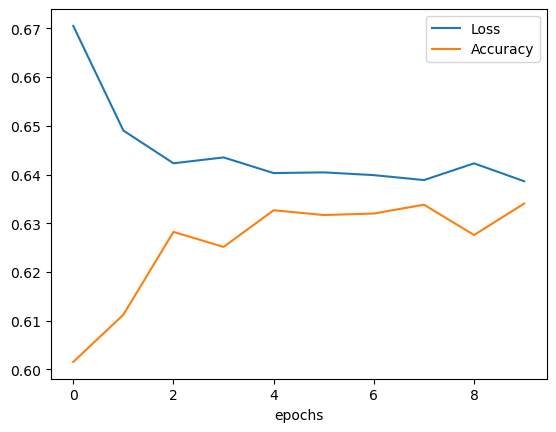

In [177]:
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['accuracy'],label='Accuracy')
plt.legend()
plt.xlabel("epochs")